
# Group B - Counter Strike GO round winner classification

Authors: ALBIN S., CKALIB N., DANIEL R., JORGE ANDRÉS R., NICOLAS G., TOMÁS F.

Data source: https://www.kaggle.com/christianlillelund/csgo-round-winner-classification

Last revision: 13/September/2020

<img src="./images/CounterStrikeGO.jpg" align="center">

# Introduction - Business Understanding

CS:GO is a tactical shooter, where two teams (CT and Terrorist) play for a best of 30 rounds, with each round being 1 minute and 55 seconds. There are 5 players on each team (10 in total) and the first team to reach 16 rounds wins the game. At the start, one team plays as CT and the other as Terrorist. After 15 rounds played, the teams swap side. There are 7 different maps a game can be played on. You win a round as Terrorist by either planting the bomb and making sure it explodes, or by eliminating the other team. You win a round as CT by either eliminating the other team, or by disarming the bomb, should it have been planted.

Learn more about CS:GO: https://en.wikipedia.org/wiki/Counter-Strike:_Global_Offensive

The dataset consists of ~700 demos from high level tournament play in 2019 and 2020. Warmup rounds and restarts have been filtered, and for the remaining live rounds a round snapshot have been recorded every 20 seconds until the round is decided. The target variable is the one called `round_winner`, taking the values `CT` for Counter-Terrorist or `T` for Terrorist.

## Steps to be followed <font color=red>[CAN BE REMOVED ONCE WE FINISH]</font>

1. Read the dataset
2. Data preparation: Check for variable types, NAs, values imputation, column names, scaling, encoding, etc.
3. EDA (Exploratory Data Analysis): Try to extract some insights from the data like features completely uncorrelated or under-represented. Can we merge values from any of the categorical features? Would it be beneficial to discretize numerical features? Do we have outliers?
3. Baseline: Simply take the simpler possible model (logistic regression) and set a base score that we'll try to improve along the process. To run logistic regression **you need** to have **numerical features**, so the fastest way of preparing your data to be used in `lr` is to perform _one hot encoding_. Perform this encoding so that you don't destroy the original prepared data. Consider to include onehot encoding as an step which is done right before evaluation over a copy of your prepared data.
4. Feature Engineering: We will try
    - categorical encoding: compare techniques like onehot and target encoding
    - feature selection: compare the results from filtering, wrappers and regularization
    - feature construction: compare GPLearn with _ad hoc_ methods, or Deep Feature Synthesis.
5. Evaluation: the goal here is to fine tune our models, so, to do that we need a new model, like **decission trees**, in this case. We will experiment with:
    - Cross validation and bootstrapping comparison.
    - Fine tune tree parameters: pruning and parameters optimization.

# Data Understanding

## Load libraries and read the dataset

In [35]:
# import libraries numpy, pandas, and scipy.stats module
import numpy as np
import pandas as pd
import scipy.stats as stats
import math
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn import tree
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_selection import RFE
from sklearn.impute import IterativeImputer
from sklearn.utils import resample
#from sklearn_pandas import CategoricalImputer
from sklearn.model_selection import cross_val_score, train_test_split

In [2]:
# import dataset using pd.read_csv() function
df = pd.read_csv("modeling_set.csv")

## Quick look at the data

In [14]:
df.describe(include = 'all')

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,...,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
count,85687.000000,85687.000000,85687.000000,85687,85687,85687.000000,85687.000000,85687.000000,85687.000000,85687.000000,...,85687.000000,85687.000000,85687.000000,85687.000000,85687.000000,85687.000000,85687.000000,85687.000000,85687.000000,85687
unique,NaN,NaN,NaN,8,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,de_inferno,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,T
freq,NaN,NaN,NaN,16568,76070,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43684
mean,97.825568,6.711742,6.767433,NaN,NaN,411.915063,402.707902,314.230245,298.340297,9782.932650,...,1.857061,1.537013,1.625929,1.000035,0.020190,0.048024,1.348734,0.028184,0.026107,NaN
std,54.482793,4.786124,4.821617,NaN,NaN,132.481120,139.958035,170.829229,174.737071,11208.283194,...,1.795516,1.735445,1.830067,1.457307,0.145383,0.227515,1.662616,0.171184,0.165699,NaN
min,0.020000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,54.920000,3.000000,3.000000,NaN,NaN,349.000000,322.000000,194.000000,173.000000,1250.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
50%,94.910000,6.000000,6.000000,NaN,NaN,500.000000,500.000000,377.000000,334.000000,5450.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,NaN
75%,166.920000,10.000000,10.000000,NaN,NaN,500.000000,500.000000,486.000000,468.000000,14650.000000,...,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000,NaN


In [15]:
df.head()

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,...,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,109.95,10.0,7.0,de_dust2,False,500.0,500.0,86.0,483.0,14900.0,...,4.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,T
1,114.95,15.0,14.0,de_inferno,False,500.0,500.0,471.0,500.0,22700.0,...,1.0,5.0,2.0,4.0,0.0,1.0,3.0,0.0,0.0,CT
2,174.95,9.0,13.0,de_mirage,False,500.0,500.0,473.0,0.0,32300.0,...,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,CT
3,34.93,14.0,15.0,de_inferno,False,468.0,489.0,495.0,495.0,2850.0,...,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,T
4,74.94,3.0,2.0,de_inferno,False,497.0,400.0,500.0,400.0,5600.0,...,2.0,2.0,3.0,3.0,0.0,0.0,1.0,0.0,0.0,T


In [16]:
df.columns

Index(['time_left', 'ct_score', 't_score', 'map', 'bomb_planted', 'ct_health',
       't_health', 'ct_armor', 't_armor', 'ct_money', 't_money', 'ct_helmets',
       't_helmets', 'ct_defuse_kits', 'ct_players_alive', 't_players_alive',
       'ct_weapon_ak47', 't_weapon_ak47', 'ct_weapon_aug', 't_weapon_aug',
       'ct_weapon_awp', 't_weapon_awp', 'ct_weapon_bizon', 't_weapon_bizon',
       'ct_weapon_cz75auto', 't_weapon_cz75auto', 'ct_weapon_elite',
       't_weapon_elite', 'ct_weapon_famas', 't_weapon_famas',
       'ct_weapon_g3sg1', 't_weapon_g3sg1', 'ct_weapon_galilar',
       't_weapon_galilar', 'ct_weapon_glock', 't_weapon_glock',
       'ct_weapon_m249', 't_weapon_m249', 'ct_weapon_m4a1s', 't_weapon_m4a1s',
       'ct_weapon_m4a4', 't_weapon_m4a4', 'ct_weapon_mac10', 't_weapon_mac10',
       'ct_weapon_mag7', 't_weapon_mag7', 'ct_weapon_mp5sd', 't_weapon_mp5sd',
       'ct_weapon_mp7', 't_weapon_mp7', 'ct_weapon_mp9', 't_weapon_mp9',
       'ct_weapon_negev', 't_weapon_negev',

In [17]:
df.dtypes

time_left                    float64
ct_score                     float64
t_score                      float64
map                           object
bomb_planted                    bool
                              ...   
ct_grenade_molotovgrenade    float64
t_grenade_molotovgrenade     float64
ct_grenade_decoygrenade      float64
t_grenade_decoygrenade       float64
round_winner                  object
Length: 97, dtype: object

In [18]:
df.dtypes.value_counts()

float64    94
object      2
bool        1
dtype: int64

Looking at the metadata and the above descriptions we conclude that map, bomb_planted and our traget round_winner are the only categorical variables. 

In [3]:
categoricals= ['map','bomb_planted', 'round_winner']

In [20]:
#Lets look at the class balance for each
for col in categoricals:
    print(col)
    res = df[col].value_counts()
    print(f'{res}\n----')

map
de_inferno     16568
de_dust2       15580
de_nuke        13244
de_mirage      13016
de_overpass     9924
de_train        9451
de_vertigo      7797
de_cache         107
Name: map, dtype: int64
----
bomb_planted
False    76070
True      9617
Name: bomb_planted, dtype: int64
----
round_winner
T     43684
CT    42003
Name: round_winner, dtype: int64
----


In [5]:
#Cast categorical values as categorical
df[categoricals]=df[categoricals].astype('category')

In [6]:
#Create numerical and categorical df
df_numerical = df.select_dtypes(include = 'float')
df_categorical = df.select_dtypes(exclude = 'float')
df_categorical.drop('round_winner', axis=1, inplace = True)

C:\Users\drodriguez45\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Let's take a look at the histograms

In [7]:
# Bokeh libraries
from bokeh.io import output_file, output_notebook
from bokeh.plotting import figure, show
from bokeh.layouts import row, column, gridplot
from bokeh.models.widgets import Tabs, Panel
from bokeh.models import ColumnDataSource, HoverTool, Panel

In [8]:
class BokehHistogram():
    '''
    A class to simplify the making of interactive histograms with the Bokeh library.
    Requires: Bokeh, Pandas, and Numpy.
    '''

    def __init__(self, colors=["SteelBlue", "Tan"], height=600, width=600):
        self.colors = colors
        self.height = height
        self.width = width

    def hist_hover(self, dataframe, column, bins=30, log_scale=False, show_plot=True):
        """
        A method for creating a single Bokeh histogram with hovertool interactivity.
        Parameters:
        ----------
        Input:
        dataframe {df}: Pandas dataframe
        column {string}: column of dataframe to plot in histogram
        bins {int}: number of bins in histogram
        log_scale {bool}: True to plot on a log scale
        colors {list -> string}: list of colors for histogram; first color default color, second color is hover color
        show_plot {bool}: True to display the plot, False to store the plot in a variable (for use in later methods)
        Output:
        plot: bokeh histogram with interactive hover tool
        """
        # build histogram data with Numpy
        hist, edges = np.histogram(dataframe[column], bins = bins)
        hist_df = pd.DataFrame({column: hist,
                                 "left": edges[:-1],
                                 "right": edges[1:]})
        hist_df["interval"] = ["%d to %d" % (left, right) for left, 
                               right in zip(hist_df["left"], hist_df["right"])]
        # bokeh histogram with hover tool
        if log_scale == True:
            hist_df["log"] = np.log(hist_df[column])
            src = ColumnDataSource(hist_df)
            plot = figure(plot_height = self.height, plot_width = self.width,
                  title = "Histogram of {}".format(column.capitalize()),
                  x_axis_label = column.capitalize(),
                  y_axis_label = "Log Count")    
            plot.quad(bottom = 0, top = "log",left = "left", 
                right = "right", source = src, fill_color = self.colors[0], 
                line_color = "black", fill_alpha = 0.7,
                hover_fill_alpha = 1.0, hover_fill_color = self.colors[1])
        else:
            src = ColumnDataSource(hist_df)
            plot = figure(plot_height = self.height, plot_width = self.width,
                  title = "Histogram of {}".format(column.capitalize()),
                  x_axis_label = column.capitalize(),
                  y_axis_label = "Count")    
            plot.quad(bottom = 0, top = column,left = "left", 
                right = "right", source = src, fill_color = self.colors[0], 
                line_color = "black", fill_alpha = 0.7,
                hover_fill_alpha = 1.0, hover_fill_color = self.colors[1])

        # hover tool
        hover = HoverTool(tooltips = [('Interval', '@interval'),
                                  ('Count', str("@" + column))])
        plot.add_tools(hover)

        # output
        if show_plot == True:
            show(plot)
        else:
            return plot

    def histotabs(self, dataframe, features, log_scale=False, show_plot=False):
        '''
        Builds tabbed interface for a series of histograms; calls hist_hover. Specifying 'show_plot=True' will simply display the histograms in sequence rather than in a tabbed interface.
        Parameters:
        ----------
        Input:
        dataframe {df}: a Pandas dataframe
        features {list -> string}: list of features to plot
        log_scale {bool}: True to plot on a log scale
        colors {list -> string}: list of colors for histogram; first color default color, second color is hover color
        show_plot {bool}: True to display the plot, False to store the plot in a variable (for use in later methods)
        Output:
        Tabbed interface for viewing interactive histograms of specified features
        '''
        hists = []
        for f in features:
            h = self.hist_hover(dataframe, f, log_scale=log_scale, show_plot=show_plot)
            p = Panel(child=h, title=f.capitalize())
            hists.append(p)
        t = Tabs(tabs=hists)
        show(t)

    def filtered_histotabs(self, dataframe, feature, filter_feature, log_scale=False, show_plot=False):
        '''
        Builds tabbed histogram interface for one feature filtered by another. Feature is numeric, fiter feature is categorical.
        Parameters:
        ----------
        Input:
        dataframe {df}: a Pandas dataframe
        features {list -> string}: list of features to plot
        log_scale {bool}: True to plot on a log scale
        colors {list -> string}: list of colors for histogram; first color default color, second color is hover color
        show_plot {bool}: True to display the plot, False to store the plot in a variable (for use in later methods)
        Output:
        Tabbed interface for viewing interactive histograms of specified feature filtered by categorical filter feature
        '''
        hists = []
        for col in dataframe[filter_feature].unique():
            sub_df = dataframe[dataframe[filter_feature] == col]
            histo = self.hist_hover(sub_df, feature, log_scale=log_scale, show_plot=show_plot)
            p = Panel(child = histo, title=col)
            hists.append(p)
        t = Tabs(tabs=hists)
        show(t)

In [9]:
#create instance of the bokeeh histogram object
h = BokehHistogram()

In [ ]:
output_notebook()
h.histotabs(df_numerical, df_numerical.columns)

## Lets look at some relationships to understand how some feature can affect the outcome of the game (Using expert knowledge)

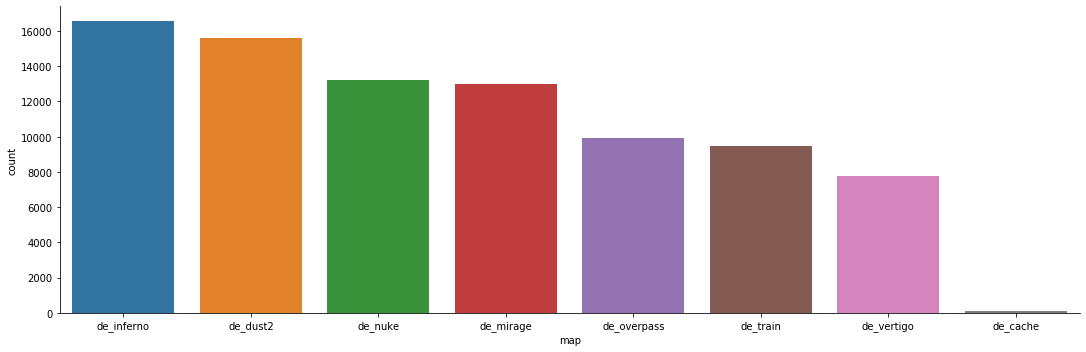

In [35]:
 import seaborn as sns
    
# We explore the maps variables
 
 sns.catplot(x="map", kind="count", data=df, height=5, aspect=3, order=df['map'].value_counts().index)

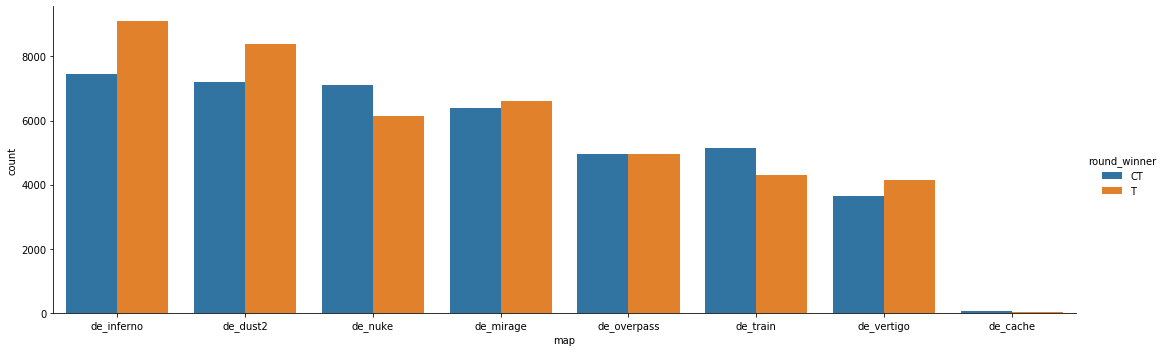

In [36]:
#Breaking down the map and the winning team
sns.catplot(x="map", hue="round_winner", kind="count", data=df, height=5, aspect=3, order=df['map'].value_counts().index)

In the two most played maps, de_inferno and de_dust2, Terrorist team wins more games than Counter-Terrorist

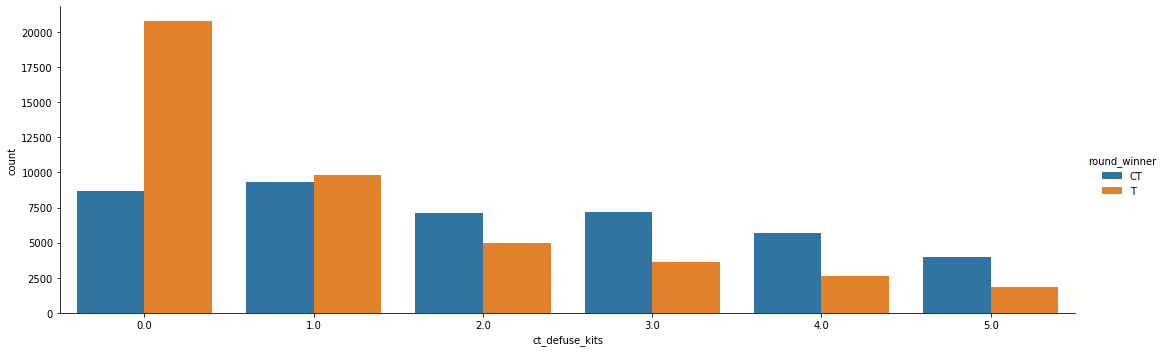

In [37]:
sns.catplot(x="ct_defuse_kits", hue="round_winner", kind="count", data=df, height=5, aspect=3)

Having more than 1 defuse kit in the Counter-Terrotist team makes CT win more rounds than T

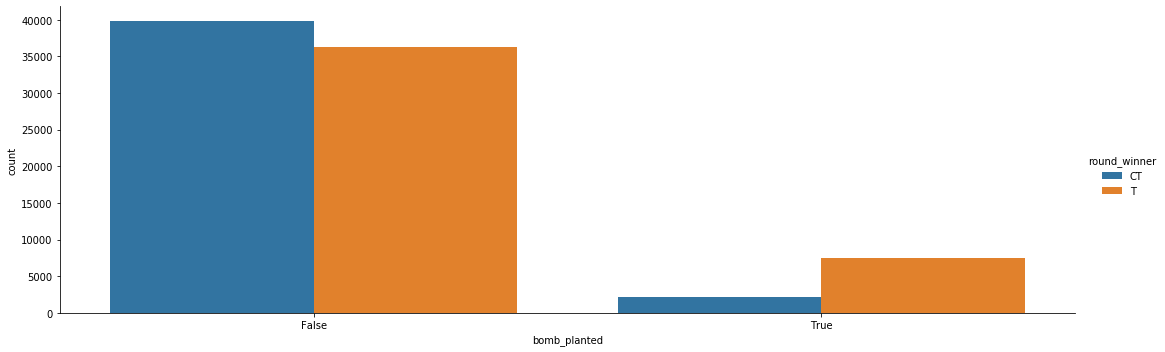

In [38]:
sns.catplot(x="bomb_planted", hue="round_winner", kind="count", data=df, height=5, aspect=3)

When Terrorists plant the bomb their win ratio is much better, but planting the bomb doesn´t happen frequetly

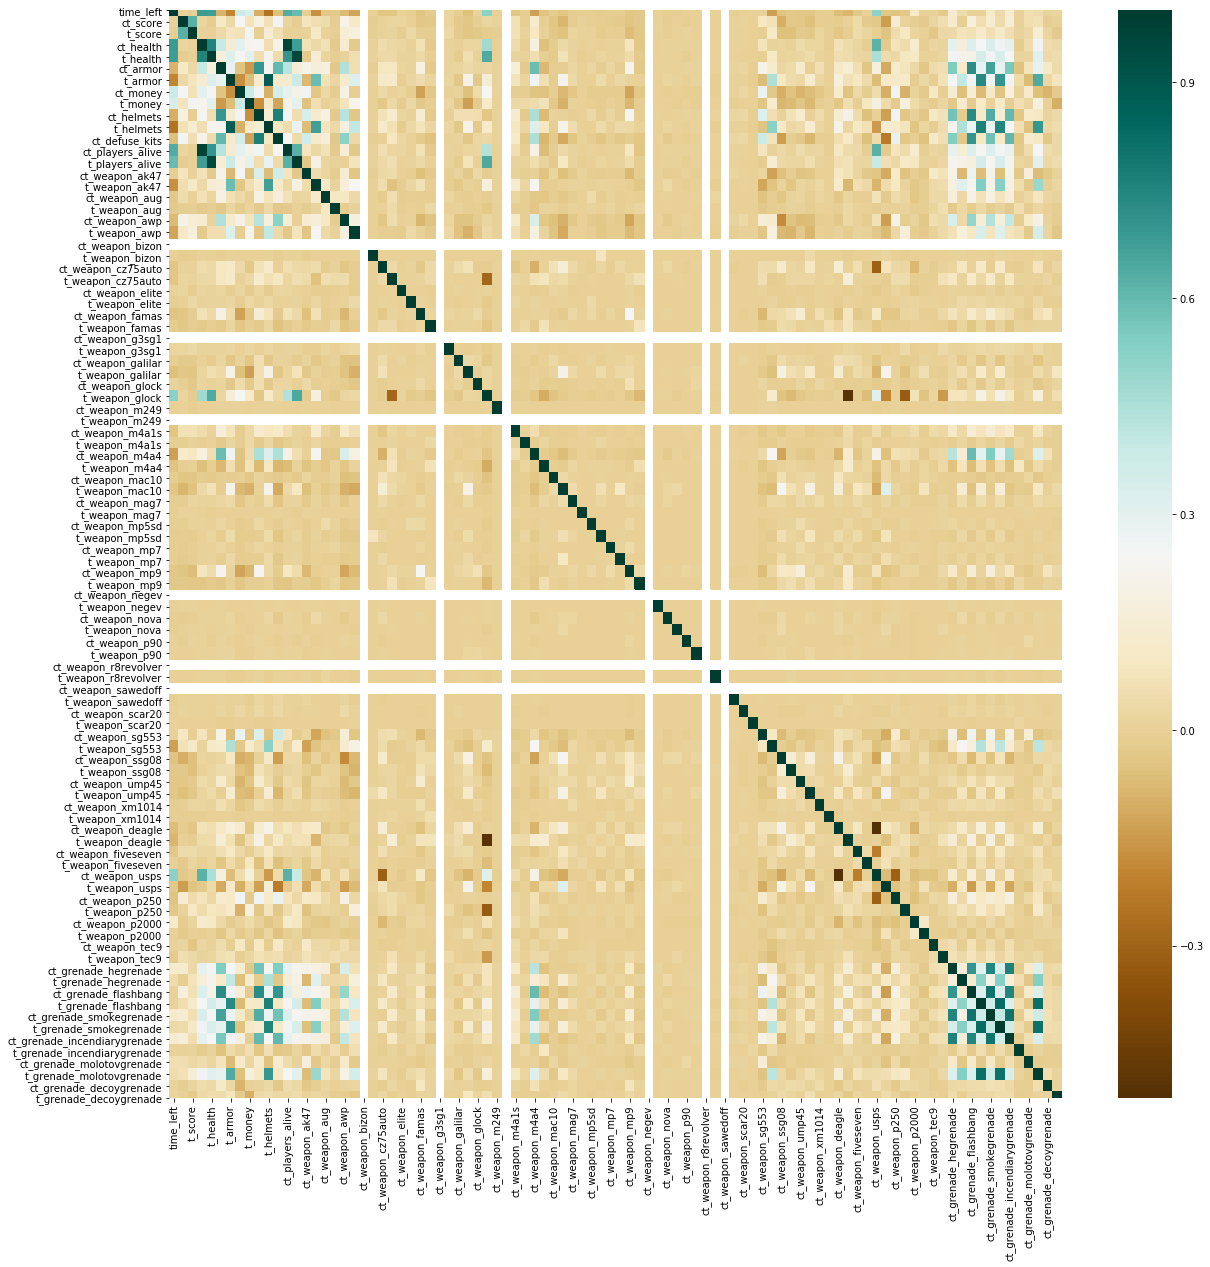

In [39]:
#create general correlation heatmap
plt.figure(figsize = (20,20))
sns.heatmap(df.corr(),cmap='BrBG')

We can see some strong correlations between features which we will explore and deal with in detail later during the feature engineering process

## Data Preparation

Impute values, drop not relevant variables, outliers, scale numerical variables

### Check for NA's

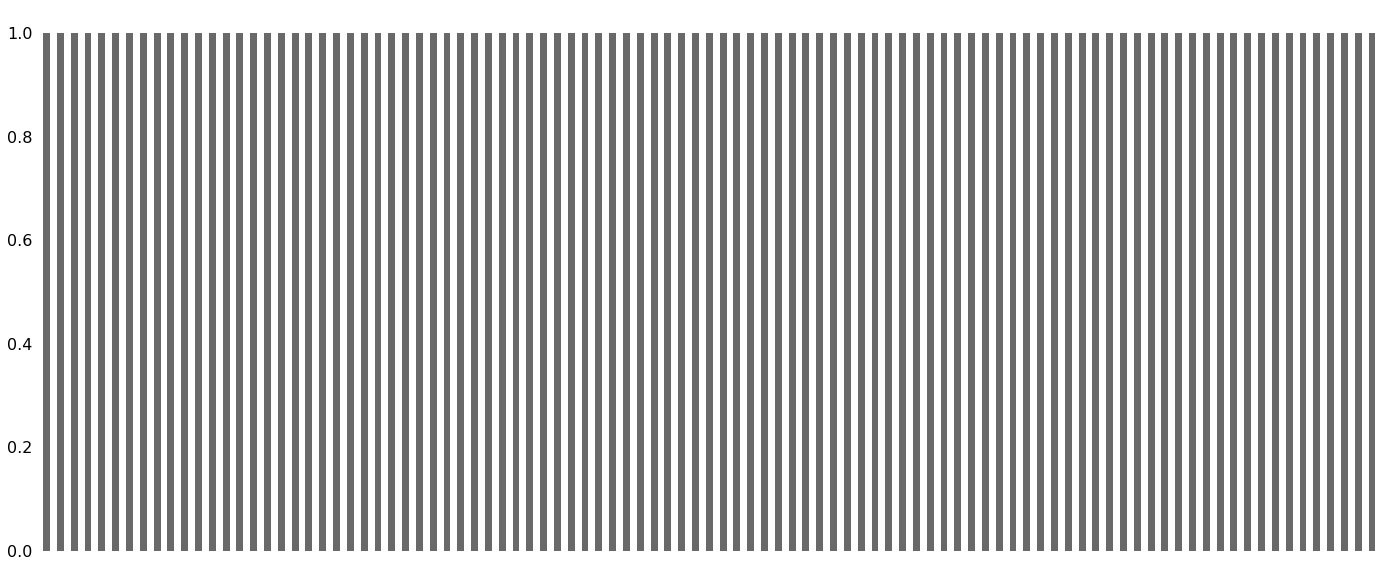

In [43]:
#Lets check graphically
#checking for missing values in the data set
import missingno as msno 
msno.bar(df)

In [44]:
# Lets double check with code

num_nas = []
for feature in df.columns:
    num_nas.append(df[feature].isna().sum())
print(f'{len(df.columns)} features have a median of {math.floor(np.median(num_nas))} NAs')

97 features have a median of 0 NAs


There are no NA's so we don't need to impute any variables

### Check for outliers

In [66]:
Q1 = df_num.quantile(0.25)
Q3 = df_num.quantile(0.75)
IQR = Q3 - Q1

#print(df_num < (Q1 - 1.5 * IQR)) |(df_num > (Q3 + 1.5 * IQR))

#df_num_out =  df_num[~(( df_num < (Q1 - 1.5 * IQR)) |( df_num > (Q3 + 1.5 * IQR))).any(axis=1)]  



In [94]:
#df_num.loc[:,((df_num < (Q1 - 1.5 * IQR)) | (df_num > (Q3 + 1.5 * IQR))).sum()<0.1*len(df)]
((((df_num < (Q1 - 1.5 * IQR)) | (df_num > (Q3 + 1.5 * IQR))).sum()/len(df))*100!=0).sum()

74

74 Columns have outliers but checking the max values of the features and with our knowledge of CS GO we decided not to remove any of these values, as all of them are possible values in a CS round.

### Low frequency variables

In [54]:
#Select columns with 1 or 0 unique values
df.loc[:, df.nunique() < 3].nunique().sort_values(ascending = True)

ct_weapon_bizon         1
ct_weapon_g3sg1         1
ct_weapon_sawedoff      1
t_weapon_m249           1
ct_weapon_r8revolver    1
ct_weapon_negev         1
bomb_planted            2
t_weapon_scar20         2
ct_weapon_scar20        2
t_weapon_sawedoff       2
t_weapon_r8revolver     2
t_weapon_p90            2
ct_weapon_p90           2
t_weapon_negev          2
ct_weapon_nova          2
t_weapon_xm1014         2
ct_weapon_mp5sd         2
t_weapon_mag7           2
ct_weapon_m249          2
t_weapon_elite          2
ct_weapon_elite         2
t_weapon_bizon          2
t_weapon_nova           2
round_winner            2
dtype: int64

'bomb_planted' and 'round_winner' are binary variables, so we expect only two unique values. The other are weapons, lets analyze those in more detail. 

In [45]:
weapons = [col for col in df.columns  if 'weapon' in col]
low_unique=list(set(weapons) & set(df.columns[df.nunique() < 3]))
low_unique

['t_weapon_m249',
 'ct_weapon_r8revolver',
 't_weapon_negev',
 't_weapon_sawedoff',
 'ct_weapon_sawedoff',
 'ct_weapon_g3sg1',
 'ct_weapon_bizon',
 't_weapon_bizon',
 't_weapon_nova',
 't_weapon_mag7',
 't_weapon_r8revolver',
 't_weapon_xm1014',
 't_weapon_elite',
 't_weapon_scar20',
 'ct_weapon_elite',
 't_weapon_p90',
 'ct_weapon_mp5sd',
 'ct_weapon_nova',
 'ct_weapon_scar20',
 'ct_weapon_negev',
 'ct_weapon_p90',
 'ct_weapon_m249']

In [58]:
#Lets look at the low unique variables 
for col in low_unique:
    print(col)
    res = df[col].value_counts()
    print(f'{res}\n----')

ct_weapon_mp5sd
0.0    85557
1.0      130
Name: ct_weapon_mp5sd, dtype: int64
----
t_weapon_xm1014
0.0    85668
1.0       19
Name: t_weapon_xm1014, dtype: int64
----
t_weapon_p90
0.0    85674
1.0       13
Name: t_weapon_p90, dtype: int64
----
ct_weapon_r8revolver
0.0    85687
Name: ct_weapon_r8revolver, dtype: int64
----
t_weapon_nova
0.0    85679
1.0        8
Name: t_weapon_nova, dtype: int64
----
t_weapon_bizon
0.0    85682
1.0        5
Name: t_weapon_bizon, dtype: int64
----
t_weapon_mag7
0.0    85685
1.0        2
Name: t_weapon_mag7, dtype: int64
----
t_weapon_sawedoff
0.0    85676
1.0       11
Name: t_weapon_sawedoff, dtype: int64
----
ct_weapon_p90
0.0    85674
1.0       13
Name: ct_weapon_p90, dtype: int64
----
ct_weapon_bizon
0.0    85687
Name: ct_weapon_bizon, dtype: int64
----
t_weapon_scar20
0.0    85686
1.0        1
Name: t_weapon_scar20, dtype: int64
----
t_weapon_m249
0.0    85687
Name: t_weapon_m249, dtype: int64
----
t_weapon_r8revolver
0.0    85684
1.0        3
Name: t

We can clearly see the above aren't ever used or not very often, so we will consider removing them in variable selection stage.

## Scaling numerical variables

In [96]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
for v in numerics:
    print(v, "- before scaling: mean= {:.10f}".format(df[v].values.mean()), " - min: {:.10f}".format(df[v].values.min()), " - max: {:.10f}".format(df[v].values.max()))
    df[v] = scaler.fit_transform(df[[v]])
    print(v, "- after scaling: mean= {:.10f}".format(df[v].values.mean()), " - min: {:.10f}".format(df[v].values.min()), " - max: {:.10f}".format(df[v].values.max()))
    print("-"*50)

time_left - before scaling: mean= 97.8255679391  - min: 0.0200000000  - max: 175.0000000000
time_left - after scaling: mean= -0.0000000000  - min: -1.7951748214  - max: 1.4165001054
--------------------------------------------------
ct_score - before scaling: mean= 6.7117415711  - min: 0.0000000000  - max: 32.0000000000
ct_score - after scaling: mean= 0.0000000000  - min: -1.4023414904  - max: 5.2836918166
--------------------------------------------------
t_score - before scaling: mean= 6.7674326327  - min: 0.0000000000  - max: 33.0000000000
t_score - after scaling: mean= 0.0000000000  - min: -1.4035689645  - max: 5.4406477926
--------------------------------------------------
ct_health - before scaling: mean= 411.9150629617  - min: 0.0000000000  - max: 500.0000000000
ct_health - after scaling: mean= 0.0000000000  - min: -3.1092540997  - max: 0.6648905957
--------------------------------------------------
t_health - before scaling: mean= 402.7079020155  - min: 0.0000000000  - max: 500

t_weapon_negev - after scaling: mean= 0.0000000000  - min: -0.0034162140  - max: 292.7217108450
--------------------------------------------------
ct_weapon_nova - before scaling: mean= 0.0009919824  - min: 0.0000000000  - max: 1.0000000000
ct_weapon_nova - after scaling: mean= 0.0000000000  - min: -0.0315113861  - max: 31.7345608594
--------------------------------------------------
t_weapon_nova - before scaling: mean= 0.0000933631  - min: 0.0000000000  - max: 1.0000000000
t_weapon_nova - after scaling: mean= -0.0000000000  - min: -0.0096629070  - max: 103.4885259340
--------------------------------------------------
ct_weapon_p90 - before scaling: mean= 0.0001517150  - min: 0.0000000000  - max: 1.0000000000
ct_weapon_p90 - after scaling: mean= 0.0000000000  - min: -0.0123181973  - max: 81.1807100998
--------------------------------------------------
t_weapon_p90 - before scaling: mean= 0.0001517150  - min: 0.0000000000  - max: 1.0000000000
t_weapon_p90 - after scaling: mean= -0.0000

In [17]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
df_numerical_std = pd.DataFrame(stdsc.fit_transform(df_numerical))
df_numerical_std.columns=df_numerical.columns

## PCA

In [105]:
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
pca = PCA(n_components=4, random_state=1)
df_transformed = pca.fit_transform(df_numerical_std)
print(f"Principal Components shape: {pca.components_.shape}")
print(f"Transformed Features shape: {df_transformed.shape}")

Principal Components shape: (4, 94)
Transformed Features shape: (85687, 4)


In [97]:
def scatter(X1, X2, y, fig, ax, title):
    colors = ["red", "green", "grey", "purple", "blue"]
    colormap = cmap = ListedColormap(colors)

    for winner in y.unique():
        i = np.where(y == winner)
        ax.scatter(X1[i], X2[i], label=f"Team {winner}", alpha=0.7)

    ax.set_title(title)
    ax.legend(loc="best")

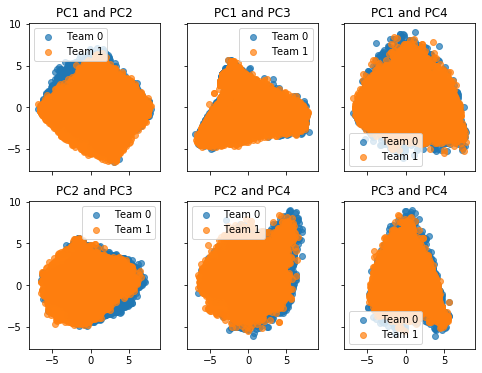

In [106]:
X = df_transformed.T
y = df['round_winner']

fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True)
fig.set_size_inches(8, 6)
scatter(X[0], X[1], y, fig, axs[0, 0], "PC1 and PC2")
scatter(X[0], X[2], y, fig, axs[0, 1], "PC1 and PC3")
scatter(X[0], X[3], y, fig, axs[0, 2], "PC1 and PC4")
scatter(X[1], X[2], y, fig, axs[1, 0], "PC2 and PC3")
scatter(X[1], X[3], y, fig, axs[1, 1], "PC2 and PC4")
scatter(X[2], X[3], y, fig, axs[1, 2], "PC3 and PC4")
#show()

It seems PCA is not helping us to classify.

# Baseline

## Logistic Regression

We will build a method to evaluate a basic Logistic Regression over a split of the data set using cross validation.

The method requires that you send it the independent variables (X) and the dependent variables (y) as a pandas DataFrame.

In [22]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, matthews_corrcoef

def evaluate_LogReg(X: pd.DataFrame, y: pd.DataFrame,
                    metric: str='accuracy',
                    seed: int=123,
                    printout: bool=False):
    """
    Fits a logistic regression with the training set, and evaluates it with 
    the test set, using Accuracy, F1, Recall or MCC metrics.

    Params
      X: A Pandas DataFrame with all the values to be used to fit the logit
      y: The dependent variable.
      metric: The metric to be returned
      printout: True/False indicating whether you want to print results

    """
    # Split the data is the first thing to do
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2)

    lr = LogisticRegression(max_iter=200).fit(X_train, y_train)
    y_hat = lr.predict(X_test)

    accuracy = accuracy_score(y_test, y_hat)
    F1 = f1_score(y_test, y_hat)
    recall = recall_score(y_test, y_hat)
    MCC = matthews_corrcoef(y_test, y_hat)
    
    if printout is True:
        print('Accuracy:', accuracy)
        print('F1:', F1)
        print('Recall:', recall)
        print('MCC:', MCC)
    
    return eval(metric)

Let's run the **baseline**. We will simply call our method with the numerical features only, simply to see what is the expected Accuracy metric. Ideally, we should call the evaluation method with all our features, but to do so, we must convert our categorical features into numbers. For baselining, we can start by simply applying a **onehot** encoding to them to see what is the result.

# Baseline with numerical features only

To start with, let's simply use numericals:

In [20]:
target = df['round_winner'].replace({'CT': 1, 'T':0})


In [23]:
from sklearn.linear_model import LogisticRegression
evaluate_LogReg(X=df_numerical_std, y=target, printout=True)

Accuracy: 0.7467032325825651
F1: 0.7427860401730164
Recall: 0.7435349940688019
MCC: 0.49329041254324224


0.7467032325825651

Now, we will try to onehot our categoricals to apply the LogisticRegression to all our features. 

# Baseline with all features (onehot)


In [26]:
# Label code binary feature
df_categorical['bomb_planted'] = df_categorical['bomb_planted'].replace({True: 1, False:0})

# Onehot map variable using pandas get_dummies
map_ohe = pd.get_dummies(df_categorical['map'], drop_first=True)

#This data frame is ready to append to df, and remove original features one hot encoded
df_categorical_ohe = pd.concat([df_categorical, map_ohe], axis=1)
df_categorical_ohe.drop('map', axis=1, inplace = True)
df_categorical_ohe

C:\Users\drodriguez45\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [27]:
# Call the evaluation method with all data in the dataset
df_copy_ohe = pd.concat([df_numerical_std, df_categorical_ohe], axis=1)
evaluate_LogReg(df_copy_ohe, target, printout=True)

Accuracy: 0.750087524798693
F1: 0.7480440025883875
Recall: 0.7568146649208427
MCC: 0.5003404344054656


0.750087524798693

## Cross Validation 

To evaluate our model in a slightly simpler way, let's use this method: `cv_classification`. It accepts a Dataset as input, and an `estimator`, which is simply the model I want to use.

Internally, it will repeat a number of times (`num_iterations`) the following steps:

  1. Randomly split the data set into training and test
  2. Fit the estimator with the training portion of the data
  3. Obtain a CV metric in training for this model
  4. Obtain a metric in test for the predictions obtained with the model just fitted in step 2
  5. Save the scores in an array to later return all of them

In [28]:
def cv_classification(X: pd.DataFrame, y: pd.DataFrame, estimator, num_iterations=20, verbose=True):
    train_scores=[]
    test_scores=[]
    for i in range(num_iterations):
        # Split the data is the first thing to do
        X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2)

        # We want to call a method whose name is the argument to this func.
        estimator.fit(X_train, y_train)
        train_metric = cross_val_score(estimator, X_train, y_train, scoring='accuracy')
        train_scores.append(np.median(train_metric))

        test_score = accuracy_score(y_test, estimator.predict(X_test))
        test_scores.append(test_score)

    if verbose:
        print('Training median Accuracy: {:.4f} +/- {:.2f}%'.format(
            np.median(train_scores), np.std(train_scores)*100.))
        print('Test Accuracy: {:.4f} +/- {:.2f}%'.format(
            np.median(test_scores), np.std(test_scores)*100.))

    return train_scores, test_scores

In [33]:
lr = LogisticRegression(max_iter = 250)
lr_train, lr_test = cv_classification(df_copy_ohe, target, lr)

Training median Accuracy: 0.7490 +/- 0.17%
Test Accuracy: 0.7516 +/- 0.28%


## Baseline with decision tree

To make things a bit simpler in our baseline, we will use a decision tree. Spending too much time cleaning our data to fit normal distributions and finding co-linearity could not be worthy in the end. So, let's try to produce a quick baseline with a single decision tree.

In [32]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
baseline_tree = DecisionTreeClassifier(random_state=123)
base_train, base_test = cv_classification(df_copy_ohe, target, baseline_tree)

Training median Accuracy: 0.7857 +/- 0.21%
Test Accuracy: 0.8007 +/- 0.40%


The interpretation from these training and test scores is the following:

* Our model, in training, is capable of achieving a 78.57% Accuracy score, with a variance of 0.21%. This is useful to check if our training is getting very high results (overfitting) or very high variance (data contains too much noise).
* Our model is expected to throw an Accuracy of 80.07% (+/- 0.40%) when predicting over unseen data.
* Since performance test is better than training performance, that's an indication that your training can be improved by tuning a bit more the parameters (too much bias).

# Feature Engineering

We are using the original data. We discard the scaled and onehot version to play with the original features to later perform the best possible encoding (not only onehot encoding). 

## Catboost encoding vs. Target encoding

We're going to compare what is the effect of encoding with Catboost or Target encoding vs. the onehot encoded proposed above for the baseline.

In [ ]:
# Uncomment this line if you haven't installed caatboos (categorical_encoders) already
# !pip install catboost

Simple `fit_transform` our data using the proposed encoder, and then:
  - we create another dataset (since we don't want to destroy the original one)
  - we add the new numerically encoded features proposed by Catboost
  - we remove the old categorical features

In [37]:
# Create the Catboost encoder, and "fit" + "transform" our data.
catboost_enc = ce.CatBoostEncoder()
map_cb= catboost_enc.fit_transform(
    df_categorical['map'], target).add_suffix('_cb')

map_cb

,map_cb
0,0.490191
1,0.490191
2,0.490191
3,0.745096
4,0.496730
...,...
85682,0.536471
85683,0.499848
85684,0.536506
85685,0.491778


In [38]:
#Create a copy of df with CatBoost encoded feature
df_categorical_cb = pd.concat([df_categorical, map_cb], axis=1)
df_categorical_cb.drop('map', axis=1, inplace = True)

df_copy_cb = pd.concat([df_numerical_std, df_categorical_cb], axis=1)

Now, train a decission tree classifier with the new data to see if we're improving a bit.

In [40]:
catboost_tree = DecisionTreeClassifier(random_state=42)
cb_train, cb_test = cv_classification(df_copy_cb, target, baseline_tree)

Training median Accuracy: 0.7770 +/- 0.22%
Test Accuracy: 0.7893 +/- 0.30%


Now it's time to try the TargetEncoder. Same steps as above

In [41]:
# Create the Target encoder, and "fit" + "transform" our data.
target_enc = ce.TargetEncoder()
map_tg= target_enc.fit_transform(
    df_categorical['map'], target).add_suffix('_tg')

#Create a copy of df with Target encoded feature
df_categorical_tg = pd.concat([df_categorical, map_tg], axis=1)
df_categorical_tg.drop('map', axis=1, inplace = True)

df_copy_tg = pd.concat([df_numerical_std, df_categorical_tg], axis=1)

In [42]:
target_tree = DecisionTreeClassifier(random_state=666)
tg_train, tg_test = cv_classification(df_copy_tg, target, target_tree)

Training median Accuracy: 0.7853 +/- 0.23%
Test Accuracy: 0.7998 +/- 0.39%


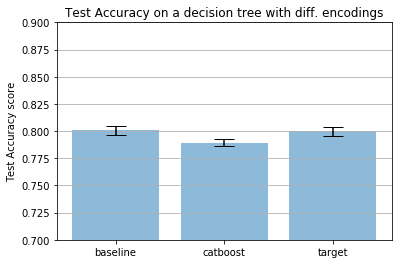

In [43]:
# Plot the three results obtained so far.
x_pos = range(3)
fig, ax = plt.subplots()
ax.bar(x_pos, 
       [np.median(base_test), np.median(cb_test), np.median(tg_test)], 
       yerr=[np.std(base_test), np.std(cb_test), np.std(tg_test)], 
       align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Test Accuracy score')
ax.set_xticks(x_pos)
ax.set_xticklabels(['baseline','catboost','target'])
ax.set_ylim([0.70, 0.90])
ax.set_title('Test Accuracy on a decision tree with diff. encodings')
ax.yaxis.grid(True)

We can see, that there's no big difference but, a priori, this experiment suggests that onehot encoding is giving us some advantage.

## Feature creation

Let´s create some features that, based on our knowledge about CS GO, could add some information to our model.

In [101]:
ct_sniper = ['ct_weapon_awp', 'ct_weapon_ssg08', 'ct_weapon_scar20', 'ct_weapon_g3sg1']
t_sniper = ['t_weapon_awp', 't_weapon_ssg08', 't_weapon_scar20', 't_weapon_g3sg1']
ct_heavy = ['ct_weapon_negev', 'ct_weapon_m249']
t_heavy = ['t_weapon_negev', 't_weapon_m249']
ct_assault = ['ct_weapon_galilar', 'ct_weapon_famas', 'ct_weapon_ak47', 'ct_weapon_m4a4', 'ct_weapon_sg553', 'ct_weapon_aug', 'ct_weapon_m4a1s']
t_assault = ['t_weapon_galilar', 't_weapon_famas', 't_weapon_ak47', 't_weapon_m4a4', 't_weapon_sg553', 't_weapon_aug', 't_weapon_m4a1s']
ct_machinegun = ['ct_weapon_mac10', 'ct_weapon_ump45','ct_weapon_mp9', 'ct_weapon_mp7', 'ct_weapon_bizon','ct_weapon_p90','ct_weapon_mp5sd']
t_machinegun = ['t_weapon_mac10', 't_weapon_ump45','t_weapon_mp9', 't_weapon_mp7', 't_weapon_bizon','t_weapon_p90','t_weapon_mp5sd']
ct_shotgun = ['ct_weapon_nova', 'ct_weapon_sawedoff', 'ct_weapon_mag7', 'ct_weapon_xm1014']
t_shotgun = ['t_weapon_nova', 't_weapon_sawedoff', 't_weapon_mag7', 't_weapon_xm1014']
ct_gun = ['ct_weapon_deagle', 'ct_weapon_fiveseven','ct_weapon_usps','ct_weapon_p250', 'ct_weapon_p2000','ct_weapon_tec9',
          'ct_weapon_glock', 'ct_weapon_cz75auto', 'ct_weapon_elite', 'ct_weapon_r8revolver']
t_gun = ['t_weapon_deagle', 't_weapon_fiveseven','t_weapon_usps','t_weapon_p250', 't_weapon_p2000','t_weapon_tec9',
          't_weapon_glock', 't_weapon_cz75auto', 't_weapon_elite', 't_weapon_r8revolver']
ct_grenade = ['ct_grenade_hegrenade', 'ct_grenade_flashbang', 'ct_grenade_smokegrenade', 'ct_grenade_incendiarygrenade',
              'ct_grenade_molotovgrenade','ct_grenade_decoygrenade']
t_grenade = ['t_grenade_hegrenade', 't_grenade_flashbang', 't_grenade_smokegrenade', 't_grenade_incendiarygrenade',
              't_grenade_molotovgrenade','t_grenade_decoygrenade']

In [304]:
#Rebuild our dataset, if we compute Genetic Programming with scaled values, we will get N/A
df_copy_ohe = pd.concat([df_numerical, df_categorical_ohe], axis=1)

In [305]:
df_copy_ohe.columns

Index(['time_left', 'ct_score', 't_score', 'ct_health', 't_health', 'ct_armor',
       't_armor', 'ct_money', 't_money', 'ct_helmets',
       ...
       'ct_grenade_decoygrenade', 't_grenade_decoygrenade', 'bomb_planted',
       'de_dust2', 'de_inferno', 'de_mirage', 'de_nuke', 'de_overpass',
       'de_train', 'de_vertigo'],
      dtype='object', length=102)

In [306]:
df_copy_ohe['round'] = df_copy_ohe.ct_score + df_copy_ohe.t_score + 1
df_copy_ohe['diff_health'] = df_copy_ohe.ct_health - df_copy_ohe.t_health
df_copy_ohe['diff_armor'] = df_copy_ohe.ct_armor - df_copy_ohe.t_armor
df_copy_ohe['diff_money'] = df_copy_ohe.ct_money - df_copy_ohe.t_money
df_copy_ohe['diff_helmets'] = df_copy_ohe.ct_helmets - df_copy_ohe.t_helmets
df_copy_ohe['diff_players_alive'] = df_copy_ohe.ct_players_alive - df_copy_ohe.t_players_alive
df_copy_ohe['diff_sniper'] = df_copy_ohe[ct_sniper].sum(axis=1) - df_copy_ohe[t_sniper].sum(axis=1)
df_copy_ohe['diff_heavy'] = df_copy_ohe[ct_heavy].sum(axis=1) - df_copy_ohe[t_heavy].sum(axis=1)
df_copy_ohe['diff_assault'] = df_copy_ohe[ct_assault].sum(axis=1) - df_copy_ohe[t_assault].sum(axis=1)
df_copy_ohe['diff_machinegun'] = df_copy_ohe[ct_machinegun].sum(axis=1) - df_copy_ohe[t_machinegun].sum(axis=1)
df_copy_ohe['diff_shotgun'] = df_copy_ohe[ct_shotgun].sum(axis=1) - df_copy_ohe[t_shotgun].sum(axis=1)
df_copy_ohe['diff_gun'] = df_copy_ohe[ct_gun].sum(axis=1) - df_copy_ohe[t_gun].sum(axis=1)
df_copy_ohe['diff_grenade'] = df_copy_ohe[ct_grenade].sum(axis=1) - df_copy_ohe[t_grenade].sum(axis=1)

### Genetic Programming for automated feature creation

So now we’ll train our transformer to generate some new features. Let’s use a population of 500 individuals over 20 generations. We’ll select the best 50 of these for the hall_of_fame, and then use the least-correlated 10 as our new features. A little parsimony should control bloat, but we’ll leave the rest of the evolution options at their defaults. As we are going to use a tree-based estimator, the Spearman correlation metric='spearman' is appropriate here.

In [276]:
#pip install gplearn
from gplearn.genetic import SymbolicTransformer

function_set = ['add', 'sub', 'mul', 'div',
                'sqrt', 'log', 'abs', 'neg', 'inv',
                'max', 'min']

gp = SymbolicTransformer(generations=20, population_size=500,
                         hall_of_fame=50, n_components=10,
                         function_set=function_set,
                         parsimony_coefficient=0.0005,
                         max_samples=0.9, verbose=1,
                         random_state=42, n_jobs=-1, metric='spearman')

gp.fit(df_copy_ohe, target)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     8.90        0.0866616        3         0.542584         0.537769      5.36m
   1     9.13         0.301229        3         0.543555         0.528987      4.46m
   2     6.03         0.433794       17         0.559399          0.55054      5.08m
   3     3.27          0.48739       21         0.560706         0.538682      3.37m
   4     9.90         0.481503       17         0.563159         0.558515      4.33m
   5    11.01         0.470309       17         0.564976         0.542043      4.39m
   6     6.53         0.481493       20         0.563726         0.553997      2.91m
   7     5.08         0.493722        5         0.563231         0.534179      2.41m
   8     4.94         0.503362        5         0.562586         0.540024  

SymbolicTransformer(const_range=(-1.0, 1.0), feature_names=None,
                    function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log',
                                  'abs', 'neg', 'inv', 'max', 'min'],
                    generations=20, hall_of_fame=50, init_depth=(2, 6),
                    init_method='half and half', low_memory=False,
                    max_samples=0.9, metric='spearman', n_components=10,
                    n_jobs=-1, p_crossover=0.9, p_hoist_mutation=0.01,
                    p_point_mutation=0.01, p_point_replace=0.05,
                    p_subtree_mutation=0.01, parsimony_coefficient=0.0005,
                    population_size=500, random_state=42, stopping_criteria=1.0,
                    tournament_size=20, verbose=1, warm_start=False)

In [277]:
gp_features = gp.transform(df_copy_ohe)
print(f'{gp_features.shape[1]} new features generated')

10 new features generated


In [278]:
# Build a dataframe from the set of best new features generated.
new_dataframe = pd.DataFrame(gp_features)
# Set the name of the dataframe columns as 'gp#' where # is a number.
new_dataframe.columns = ['gp{}'.format(i) for i in range(len(list(new_dataframe)))]

# Add the new dataframe as new columns of my dataset
df_copy_ohe = pd.concat([df_copy_ohe, new_dataframe], axis=1)

# Show it
df_copy_ohe.head()

,time_left,ct_score,t_score,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,...,gp0,gp1,gp2,gp3,gp4,gp5,gp6,gp7,gp8,gp9
0,109.95,10.0,7.0,500.0,500.0,86.0,483.0,14900.0,10400.0,0.0,...,397.0,397.0,397.0,397.0,397.0,397.0,397.0,397.0,397.0,794.0
1,114.95,15.0,14.0,500.0,500.0,471.0,500.0,22700.0,3500.0,5.0,...,29.0,29.0,29.0,29.0,29.0,29.0,29.0,29.0,29.0,58.0
2,174.95,9.0,13.0,500.0,500.0,473.0,0.0,32300.0,21600.0,5.0,...,-473.0,-473.0,-473.0,-473.0,-473.0,-473.0,-473.0,-473.0,-473.0,-946.0
3,34.93,14.0,15.0,468.0,489.0,495.0,495.0,2850.0,2250.0,5.0,...,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,43.0
4,74.94,3.0,2.0,497.0,400.0,500.0,400.0,5600.0,3050.0,4.0,...,-197.0,-197.0,-197.0,-197.0,-197.0,-197.0,-197.0,-197.0,-197.0,-394.0


In [279]:
df_copy_ohe.describe()

,time_left,ct_score,t_score,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,...,gp0,gp1,gp2,gp3,gp4,gp5,gp6,gp7,gp8,gp9
count,85687.000000,85687.000000,85687.000000,85687.000000,85687.000000,85687.000000,85687.000000,85687.000000,85687.000000,85687.000000,...,85687.000000,85687.000000,85687.000000,85687.000000,85687.000000,85687.000000,85687.000000,85687.000000,85687.000000,85687.000000
mean,97.825568,6.711742,6.767433,411.915063,402.707902,314.230245,298.340297,9782.932650,11206.763570,2.053474,...,-24.989683,-24.989683,-24.989683,-24.989683,-24.989683,-24.989683,-24.989683,-24.989683,-24.989683,-50.086793
std,54.482793,4.786124,4.821617,132.481120,139.958035,170.829229,174.737071,11208.283194,12108.264354,1.838961,...,265.470140,265.470140,265.470140,265.470140,265.470140,265.470140,265.470140,265.470140,265.470140,530.871086
min,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-1000.000000,-2000.000000
25%,54.920000,3.000000,3.000000,349.000000,322.000000,194.000000,173.000000,1250.000000,1600.000000,0.000000,...,-193.000000,-193.000000,-193.000000,-193.000000,-193.000000,-193.000000,-193.000000,-193.000000,-193.000000,-386.000000
50%,94.910000,6.000000,6.000000,500.000000,500.000000,377.000000,334.000000,5450.000000,7100.000000,2.000000,...,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-4.000000
75%,166.920000,10.000000,10.000000,500.000000,500.000000,486.000000,468.000000,14650.000000,17950.000000,4.000000,...,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,230.000000
max,175.000000,32.000000,33.000000,500.000000,500.000000,500.000000,500.000000,80000.000000,80000.000000,5.000000,...,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,1836.000000


# Feature Selection

Let's filter out some attributes that might be too much correlated or not leading to good performance.

### Filtering

Remove the weapons we already know are never used after EDA

In [307]:
df_copy_ohe.drop(low_unique, axis=1, inplace = True)

In [105]:
#Test if we are improving our baseline
_, _ = cv_classification(df_copy_ohe, target, baseline_tree)

Training median Accuracy: 0.7866 +/- 0.26%
Test Accuracy: 0.8010 +/- 0.37%


### Correlation

Data columns with very similar trends are also likely to carry very similar information. In this case, only one of them will suffice to feed the machine learning model. Here we calculate the correlation coefficient between columns as the Coefficient and the Pearson’s chi square value respectively. Pairs of columns with correlation coefficient higher than a threshold are reduced to only one.

We are going to consider features with a correlation coefficient above 0.8 for our model

In [281]:
#select features with coefficient above 0.8
from sklearn.feature_selection import VarianceThreshold
correlated_features = set()
correlation_matrix = df_copy_ohe.corr()

for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [282]:
#check shape
len(correlated_features)

20

In [283]:
print(correlated_features)

{'gp0', 'gp1', 'gp5', 'diff_gun', 'gp7', 'ct_grenade_incendiarygrenade', 'diff_players_alive', 't_players_alive', 't_grenade_smokegrenade', 'gp8', 't_helmets', 'round', 'gp9', 'gp2', 'ct_grenade_smokegrenade', 't_grenade_molotovgrenade', 'gp3', 'gp6', 'ct_players_alive', 'gp4'}


In [130]:
#df_copy_ohe.drop(correlated_features, axis=1, inplace = True)

In [133]:
#Test if we are improving our baseline
_, _ = cv_classification(df_copy_ohe, target, baseline_tree)

Training median Accuracy: 0.7847 +/- 0.25%
Test Accuracy: 0.7989 +/- 0.36%


The change in performance for Tree based methods is very small. We decide ***NOT to remove*** correlated variables. We could have done it in order to improve computation time and symplicity of the model and just in case we need a Linear model with strong asumptions about multi-collinearity. 

But because we will use Recursive Feature Elimination and tree based methods it is not needed.

### Feature importance

Use Random Forest Classifier to evaluate feature importance

In [308]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df_copy_ohe.columns

forest = RandomForestClassifier(n_estimators=500, random_state=42)

forest.fit(df_copy_ohe, target)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(df_copy_ohe.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                           feat_labels[indices[f]],
                           importances[indices[f]]))

 1) diff_armor                     0.085413
 2) diff_assault                   0.046420
 3) diff_helmets                   0.045778
 4) ct_armor                       0.041116
 5) t_armor                        0.040708
 6) diff_money                     0.040458
 7) ct_money                       0.037692
 8) t_money                        0.037267
 9) diff_health                    0.036853
10) time_left                      0.031223
11) diff_grenade                   0.029948
12) diff_players_alive             0.029891
13) diff_gun                       0.023891
14) ct_score                       0.023833
15) t_score                        0.023657
16) t_helmets                      0.020869
17) round                          0.020666
18) ct_defuse_kits                 0.017874
19) t_health                       0.016241
20) ct_grenade_flashbang           0.015807
21) ct_helmets                     0.015794
22) ct_health                      0.014991
23) t_grenade_flashbang         

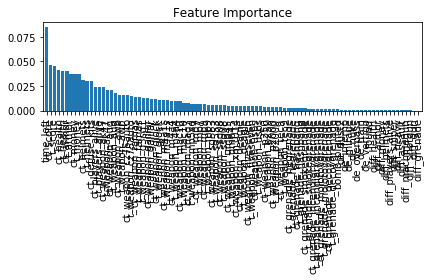

In [309]:
plt.title('Feature Importance')
plt.bar(range(df_copy_ohe.shape[1]),
       importances[indices],
       align='center')

plt.xticks(range(df_copy_ohe.shape[1]),
          feat_labels, rotation=90)
plt.xlim([-1, df_copy_ohe.shape[1]])
plt.tight_layout()
plt.show()

In [310]:
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(forest, threshold=0.003, prefit=True)
X_selected = sfm.transform(df_copy_ohe)
print('Number of features that fit this criteria:', X_selected.shape[1])

Number of features that fit this criteria: 61


In [311]:
for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                           feat_labels[indices[f]],
                           importances[indices[f]]))

 1) diff_armor                     0.085413
 2) diff_assault                   0.046420
 3) diff_helmets                   0.045778
 4) ct_armor                       0.041116
 5) t_armor                        0.040708
 6) diff_money                     0.040458
 7) ct_money                       0.037692
 8) t_money                        0.037267
 9) diff_health                    0.036853
10) time_left                      0.031223
11) diff_grenade                   0.029948
12) diff_players_alive             0.029891
13) diff_gun                       0.023891
14) ct_score                       0.023833
15) t_score                        0.023657
16) t_helmets                      0.020869
17) round                          0.020666
18) ct_defuse_kits                 0.017874
19) t_health                       0.016241
20) ct_grenade_flashbang           0.015807
21) ct_helmets                     0.015794
22) ct_health                      0.014991
23) t_grenade_flashbang         

In [312]:
base_fs_train, base_fs_test = cv_classification(X_selected, target, baseline_tree)

Training median Accuracy: 0.7829 +/- 0.27%
Test Accuracy: 0.7963 +/- 0.37%


We got the same accuracy than our baseline models with less than a half of features

Correlated features will show in a tree similar and lowered importance, compared to what their importance would be if the tree was built without correlated counterparts. In situations like this, it is better to select features recursively, rather than all together as we have done here.

### Recursive Feature Elimination

Let's start by using Recursive Feature Elimination from sklearn. It's a sophisticated implementation of stepwise selection, but with recursive decisions instead of single-step decisions. The parameters we need to have in order to use it are:
  - A model –our decision tree, in our case
  - The number of features we want to be finally selected
  - The `step` which is the nr. of features to be removed at each iteration.

In [67]:
# A function that calls RFE and returns the best features found
def rfe(data, num_features):
    estimator = DecisionTreeClassifier(random_state=123)
    selector = RFE(estimator, num_features, step=1)
    selector = selector.fit(data, target)
    return selector.support_

This piece of code will evaluate a range of possible subsets of features, from 15 to 60 features included. At each iteration, it will keep the test score to later plot it, and see what is the best strategy to choose.

In [ ]:
# Loop over the range of features in our dataset and capture results.
rfe_test_scores = pd.DataFrame()
min_range = 15
max_range = len(df_copy_ohe.columns)
rfe_tree = DecisionTreeClassifier(random_state=666)

# This is a loop over all possible values I want to evaluate
for num_features in range(min_range, max_range):
    # Obtain the best features
    best_features = rfe(df_copy_ohe, num_features)
    # Build a new dataset ONLY with best features selected.
    data_rfe = df_copy_ohe[df_copy_ohe.columns[best_features]]

    # Evaluate (CV) what is the Accuracy of this dataset
    _, test_accuracy = cv_classification(data_rfe, target, rfe_tree, verbose=False)
    
    # Keep results to later plot them
    rfe_test_scores = rfe_test_scores.append(pd.Series(test_accuracy), ignore_index=True)
    del(data_rfe)

In [ ]:
x_pos = range(min_range, max_range)

fig, ax = plt.subplots(figsize=(20,8))
ax.boxplot(rfe_test_scores)
ax.set_ylabel('Test Accuracy score')
ax.set_xticks(range(1, len(x_pos)))
ax.set_xticklabels(x_pos)
# ax.set_ylim([0.50, 0.9])
ax.set_title('Test Accuracy with varying nr. of features')
ax.yaxis.grid(True, color="gray", linestyle='--', linewidth=0.4)

From the experiment, 60 features is the best option. It also presents a not very high variance. So, now I call RFE asking it to return me 60 features and continue.

In [313]:
best_features = rfe(df_copy_ohe, 60)
data_rfe = df_copy_ohe[df_copy_ohe.columns[best_features]]

Check that this selection keeps the performance observed in the previous experiment.

In [314]:
rfe_train, rfe_test = cv_classification(data_rfe, target, rfe_tree)

Training median Accuracy: 0.7828 +/- 0.28%
Test Accuracy: 0.7973 +/- 0.46%


RFE gives the same result than the baseline tree but with only 60 features. 

### Select best dataset

In [315]:
data = data_rfe
target = target

# Evaluation and Validation

First topic to explore is how to reduce the variance in test, since we've a large number as a result of applyin the CV process in `cv_classification()`. This type of issues is normally addressed using **bootstrapping**. 

We should also take a deeper **look into our classification results** to be sure that our metric is capturing well positive and negative cases. Let's see how to access the different classifications obtained in our test set, to see from there if we can improve our metric.

Finally, compare our best single-decision-tree with **bagging** and **random forests**.

As the CS:GO Kaggle competition is now closed, so we must evaluate your results using an alternative method. 
Remember that the validation set will be used to obtain the FINAL score of your model, not the intermediate validation scores that will help you to determine whether your model is overfitting. So, you will need to further split your data (X and y) sets into training and test.

In [316]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data,
    target,
    test_size=0.3,
    random_state=42,
    stratify=target)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(59980, 60)
(25707, 60)
(59980,)
(25707,)


## Bootstrapping

Bootstrapping is a technique that can be used to estimate population statistics by repeatedly sampling with replacement and measuring. But this technique can also be used to perform model validation in a very similar way to cross-validation: we will evaluate our model with bootstrapped samples of our population.

Out method `bootstrap_split()` will simply accept all the features, and the target variable to produce two sets: training and test. This is the same idea we use when we split a dataset, but instead of taking a random number of samples out of the original data, _bootstrapping_ will perform sampling with repetition. That is the part that the method `resample()` does.

In [164]:
def bootstrap_split(X, y, seed, training_size=0.8):
    train_num_samples = X.shape[0]
    X_train, y_train = resample(X, y, replace=True, 
                                n_samples=int(train_num_samples * 0.8),
                                random_state=seed)

    # Take the indices present in the training samples
    indices_in_training = X_train.index.to_list()

    # Those, NOT in training are, go to the test set.
    X_test = X[~X.index.isin(indices_in_training)]
    y_test = y[~y.index.isin(indices_in_training)]

    return X_train, y_train, X_test, y_test

Once we've our splitting method, it's time to repeat the process of splitting and evaluating to have a decent idea of what can we expect from our model in test. These results will, ideally, produce less variance in its estimates.

In [165]:
bs_scores = []  # I will use this to keep every score produced in test.
bs_tree = DecisionTreeClassifier(random_state=666)

for i in range(100):
    X_train, y_train, X_test, y_test = bootstrap_split(data, target, seed=i*23)
    bs_tree.fit(X_train, y_train)
    
    train_metric = cross_val_score(bs_tree, X_train, y_train, scoring='accuracy')
    test_score = accuracy_score(y_test, bs_tree.predict(X_test))
    bs_scores.append(test_score)

print("Accuracy (bootstrapping) in test: %0.4f (+/- %0.2f)" % (np.median(bs_scores), np.std(bs_scores)))

Accuracy (bootstrapping) in test: 0.7755 (+/- 0.00)


As you can see, the variance (std) in our metric is significantly lower... which means that we're a bit more confident about our model's performance, by using this metric.

## Classification results

Let's plot the decision tree to check some useful information that we can find in the plot. 

  - Both categories (in our binomial classification problem) are represented with the two colors: the more intense the color, the higher the purity of the classification. Lighter nodes have Gini indices close to 0.5 (maximum impurity).
  - Every node shows you the nr. of samples that felt into each of the casses (value = [class1, class2])
  - The decision is also represented, so you can also see what're the features that play more important roles in the classification.

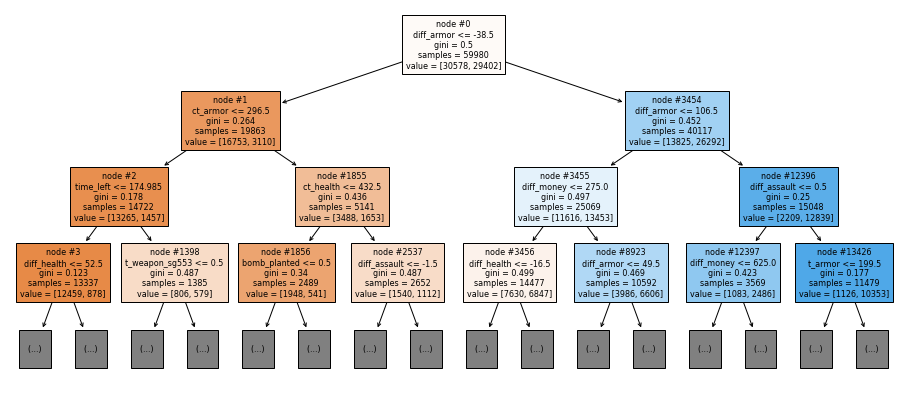

In [317]:
# Train
my_tree = DecisionTreeClassifier(random_state=666)
my_tree.fit(X_train, y_train)

# Plot
plt.figure(figsize=(16, 7))
tree.plot_tree(my_tree, feature_names=data.columns, 
               node_ids=True, filled=True, fontsize=8, max_depth=3);

This method allows us to know what are the Gini values for each classification performed on a test set (`X_test`). You only need to pass the fitted tree (_estimator_) and the test set to obtain in return an array with all the Gini values obtained.

In [175]:
def get_impurity(estimator, X_test, verbose=False):
    impurity = []
    leave_id = estimator.apply(X_test)
    node_indicator = estimator.decision_path(X_test)
    feature = estimator.tree_.feature
    threshold = estimator.tree_.threshold

    for sample_id in range(X_test.shape[0]):
        node_index = node_indicator.indices[
            node_indicator.indptr[sample_id]:
            node_indicator.indptr[sample_id + 1]]
        leave = estimator.tree_.__getstate__()['nodes'][leave_id[sample_id]]
        if verbose:
            print(f"sample {sample_id:>3d} predicted at leave ID #{leave_id[sample_id]:>2d}. ", end="")
            print(f"Impurity (Gini): {leave[4]:.4f}")
        impurity.append(leave[4])
    
    return impurity

To see what our predictions look like, we can plot the histogram of the Gini values. Ideally we'd see lots of values close to zero, and not so many close to 0.5. In our case, our predictions are good.

Anyway, as our train results are worse that test results we can increase the complexity of the tree (bagging, boosting, random forests, ...) to name a few.

Text(0, 0.5, 'Numer of samples')

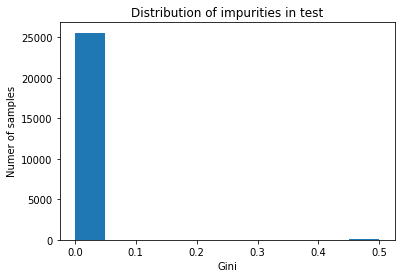

In [318]:
impurities = get_impurity(my_tree, X_test)

plt.hist(impurities);
plt.title('Distribution of impurities in test')
plt.xlabel('Gini')
plt.ylabel('Numer of samples')

## Bagging and Random Forests

As a final step, we can concentrate on whether the model selected is the best possible option. We can compare our results with a single tree against the option of using Random Forest or Bagging trees, and compare the score obtained in test, with the single tree model.

In [300]:
forest = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42)

In [319]:
forest.fit(X_train, y_train)
train_metric = cross_val_score(forest, X_train, y_train, scoring='accuracy')
test_score = accuracy_score(y_test, forest.predict(X_test))

print('Training median Accuracy: {:.4f} +/- {:.2f}%'.format(
            np.median(train_metric), np.std(train_metric)*100.))
print('Test Accuracy: {:.4f}'.format(test_score))

Training median Accuracy: 0.8412 +/- 0.18%
Test Accuracy: 0.8519


In [ ]:
from sklearn.ensemble import BaggingClassifier

bagging = BaggingClassifier(DecisionTreeClassifier(random_state=666), n_estimators = 100)

bagging.fit(X_train, y_train)
train_metric = cross_val_score(bagging, X_train, y_train, scoring='accuracy')
test_score = accuracy_score(y_test, bagging.predict(X_test))

print('Training median Accuracy: {:.4f} +/- {:.2f}%'.format(
            np.median(train_metric), np.std(train_metric)*100.))
print('Test Accuracy: {:.4f}'.format(test_score))

## Validation

Once we have our best model, it is time to predict using the Validation set, which previously needs to be transformed.

In [323]:
# import dataset using pd.read_csv() function
df = pd.read_csv("validation_set.csv")

#Create numerical and categorical df
df_numerical = df.select_dtypes(include = 'float')
df_categorical = df.select_dtypes(exclude = 'float')
df_categorical.drop('round_winner', axis=1, inplace = True)

# Label code binary feature
df_categorical['bomb_planted'] = df_categorical['bomb_planted'].replace({True: 1, False:0})

# Onehot map variable using pandas get_dummies
map_ohe = pd.get_dummies(df_categorical['map'], drop_first=True)

#This data frame is ready to append to df, and remove original features one hot encoded
df_categorical_ohe = pd.concat([df_categorical, map_ohe], axis=1)
df_categorical_ohe.drop('map', axis=1, inplace = True)

df_copy_ohe = pd.concat([df_numerical, df_categorical_ohe], axis=1)

#Create new features
df_copy_ohe['round'] = df_copy_ohe.ct_score + df_copy_ohe.t_score + 1
df_copy_ohe['diff_health'] = df_copy_ohe.ct_health - df_copy_ohe.t_health
df_copy_ohe['diff_armor'] = df_copy_ohe.ct_armor - df_copy_ohe.t_armor
df_copy_ohe['diff_money'] = df_copy_ohe.ct_money - df_copy_ohe.t_money
df_copy_ohe['diff_helmets'] = df_copy_ohe.ct_helmets - df_copy_ohe.t_helmets
df_copy_ohe['diff_players_alive'] = df_copy_ohe.ct_players_alive - df_copy_ohe.t_players_alive
df_copy_ohe['diff_sniper'] = df_copy_ohe[ct_sniper].sum(axis=1) - df_copy_ohe[t_sniper].sum(axis=1)
df_copy_ohe['diff_heavy'] = df_copy_ohe[ct_heavy].sum(axis=1) - df_copy_ohe[t_heavy].sum(axis=1)
df_copy_ohe['diff_assault'] = df_copy_ohe[ct_assault].sum(axis=1) - df_copy_ohe[t_assault].sum(axis=1)
df_copy_ohe['diff_machinegun'] = df_copy_ohe[ct_machinegun].sum(axis=1) - df_copy_ohe[t_machinegun].sum(axis=1)
df_copy_ohe['diff_shotgun'] = df_copy_ohe[ct_shotgun].sum(axis=1) - df_copy_ohe[t_shotgun].sum(axis=1)
df_copy_ohe['diff_gun'] = df_copy_ohe[ct_gun].sum(axis=1) - df_copy_ohe[t_gun].sum(axis=1)
df_copy_ohe['diff_grenade'] = df_copy_ohe[ct_grenade].sum(axis=1) - df_copy_ohe[t_grenade].sum(axis=1)

#Remove low variance
df_copy_ohe.drop(low_unique, axis=1, inplace = True)

#Select best with RFE
data_rfe = df_copy_ohe[df_copy_ohe.columns[best_features]]

C:\Users\drodriguez45\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\drodriguez45\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [324]:
#Validation dataset
X_val = data_rfe
y_val = df['round_winner'].replace({'CT': 1, 'T':0})

In [327]:
#Predict 
y_hat = forest.predict(X_val)
val_score = accuracy_score(y_val, y_hat)
print('Validation Accuracy: {:.4f}'.format(val_score))

Validation Accuracy: 0.8523


In [331]:
np.savetxt('validation_prediction.csv', y_hat, delimiter=',')